In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import invwishart
import tqdm
from numba import jit
import copy
import tqdm
import seqm
plt.style.use('dark_background')

** Gaussian **
Mean
[-5.36423815e-05  1.92103861e-04]
Covariance
[[1.06548827e-04 6.32217129e-06]
 [6.32217129e-06 9.81685066e-05]]


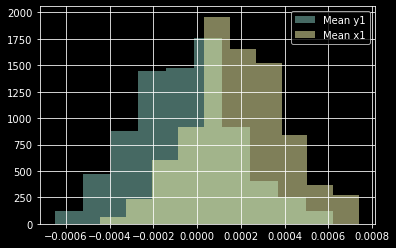

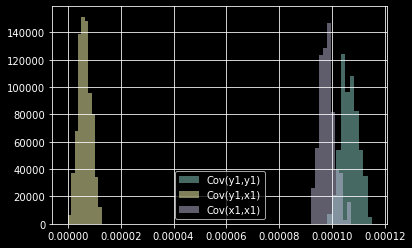

-> ACCEPT STRATEGY

** Performance summary **

Return:  0.11593308948990777
Standard deviation:  0.0797035962658303
Sharpe:  1.454552804659448

Return fee=0:  0.11593308948990777
Standard deviation fee=0:  0.0797035962658303
Sharpe fee=0:  1.454552804659448

**


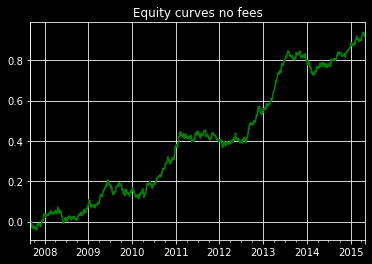

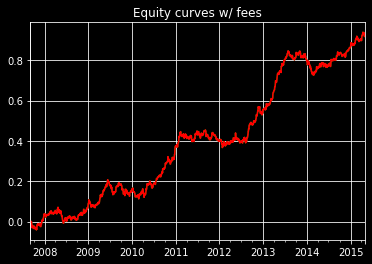

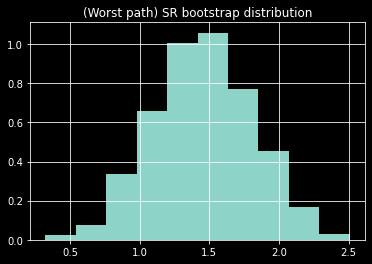

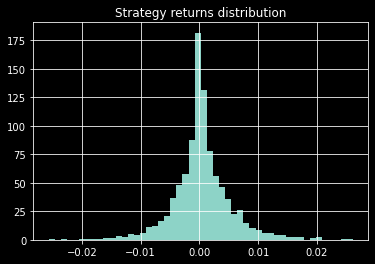

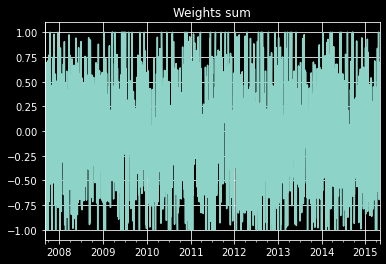

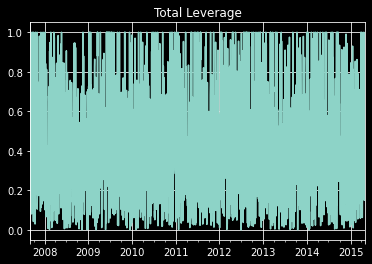

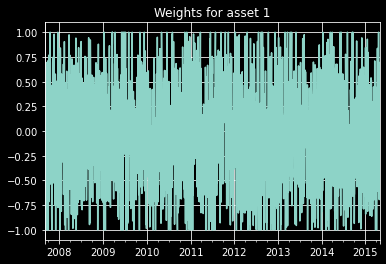

In [4]:
# Linear regression/gaussian/gaussian mixture
# Test the train test!

# generate data
n=2000
a=0
b=0.1

x=np.random.normal(0,0.01,n)
y=a+b*x+np.random.normal(0,0.01,n)
dates=pd.date_range('2000-01-01',periods=n,freq='B')
data_train=pd.DataFrame(np.hstack((y[:,None],x[:,None])),columns=['y1','x1'],index=dates)

x=np.random.normal(0,0.01,n)
y=a+b*x+np.random.normal(0,0.01,n)
dates=pd.date_range(dates[-1],periods=n+1,freq='B')[1:]
data_test=pd.DataFrame(np.hstack((y[:,None],x[:,None])),columns=['y1','x1'],index=dates)

# run model
model=seqm.ConditionalGaussian(n_gibbs=250)
bt=seqm.Inference(
                        k_folds=5,
                        burn_f=0.1,
                        n_paths=5,   
                        )
trained_model=bt.train(data_train,model)

out=bt.test(data_test,trained_model)
out.post_process()


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


-> ACCEPT STRATEGY

** Performance summary **

Return:  0.12518793778873108
Standard deviation:  0.07927799152915085
Sharpe:  1.5791007740489862

Return fee=0:  0.12518793778873108
Standard deviation fee=0:  0.07927799152915085
Sharpe fee=0:  1.5791007740489862

**


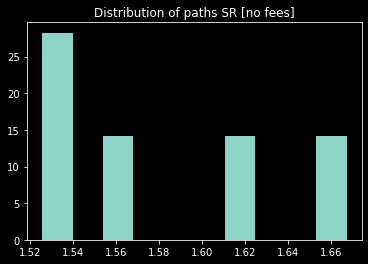

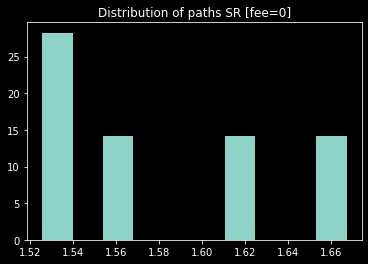

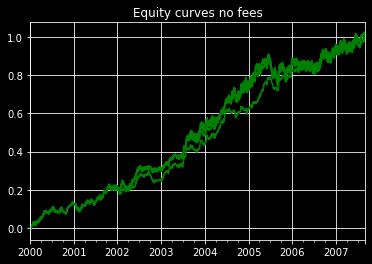

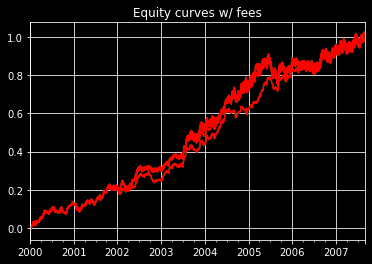

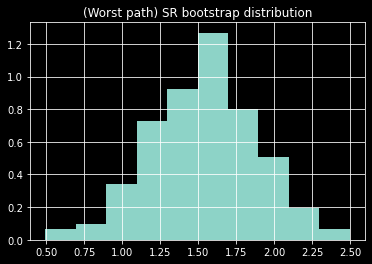

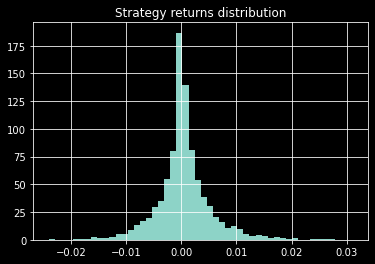

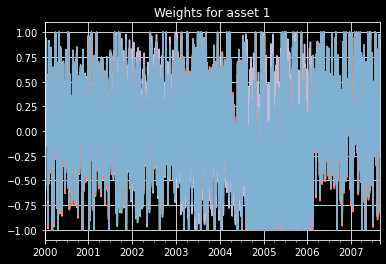

In [4]:
# Linear regression/gaussian/gaussian mixture

# generate data
n=2000
x=np.random.normal(0,0.01,n)
a=0
b=0.1
y=a+b*x+np.random.normal(0,0.01,n)
dates=pd.date_range('2000-01-01',periods=n,freq='B')
data=pd.DataFrame(np.hstack((y[:,None],x[:,None])),columns=['y1','x1'],index=dates)

# run model
model=seqm.ConditionalGaussian(n_gibbs=250)
bt=seqm.Inference(
                        k_folds=5,
                        burn_f=0.1,
                        n_paths=5,   
                        )
out=bt.cvbt(data,model)
out.post_process()


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.25s/it]


-> ACCEPT STRATEGY

** Performance summary **

Return:  0.08669590947444958
Standard deviation:  0.05490068554712768
Sharpe:  1.5791407449735455

Return fee=0:  0.08669590947444958
Standard deviation fee=0:  0.05490068554712768
Sharpe fee=0:  1.5791407449735455

**


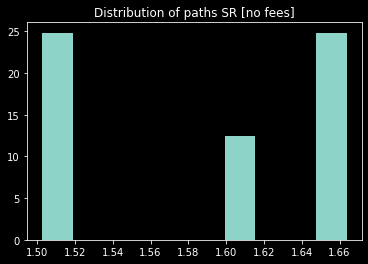

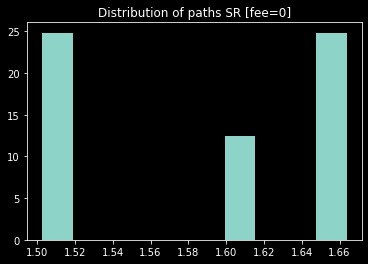

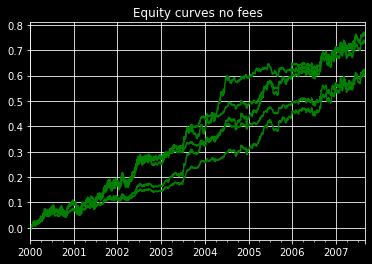

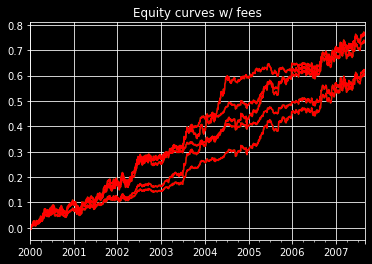

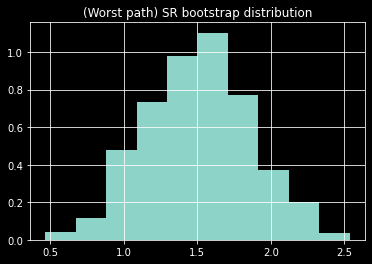

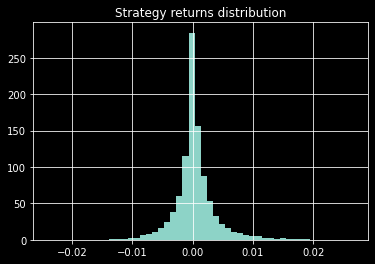

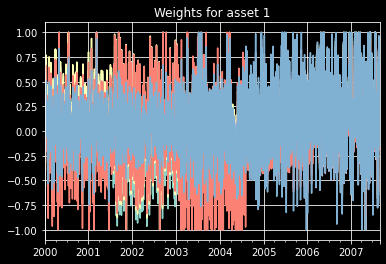

In [6]:
# use the same data as the previous example
model=seqm.ConditionalGaussianMixture(n_states=2,n_gibbs=500)

bt=seqm.Inference(
                        k_folds=5,
                        burn_f=0.1,
                        n_paths=5,   
                        )
out=bt.cvbt(data,model)
out.post_process()



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 106.36it/s]


-> ACCEPT STRATEGY

** Performance summary **

Return:  21.388443750032508
Standard deviation:  4.291803250248782
Sharpe:  4.983556445368898

Return fee=0:  21.388443750032508
Standard deviation fee=0:  4.291803250248782
Sharpe fee=0:  4.983556445368898

**


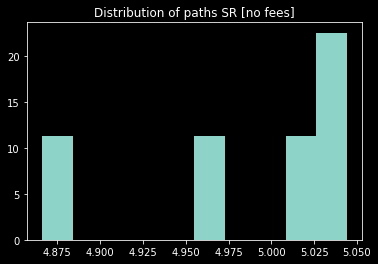

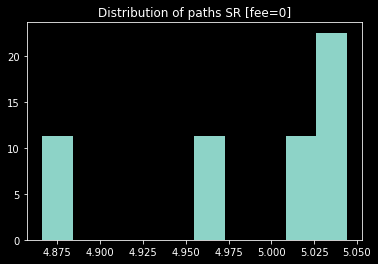

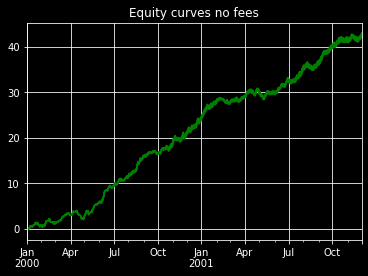

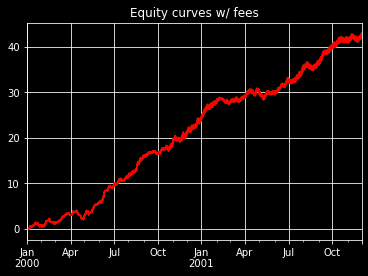

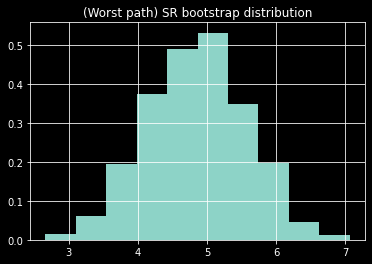

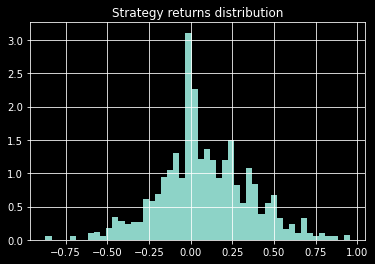

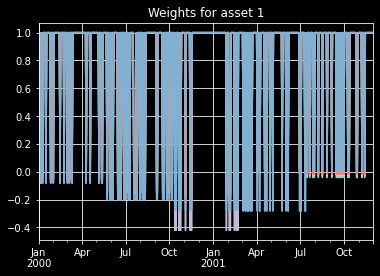

In [7]:
# data now contains observed states, for example model for different weekdays
phi=np.array([0.8,0.2])
means=[
        np.array([0.1]),
        np.array([-0.1])
    ] # let the means be different from zero 

# list of covariance matrices (for each mixture)
covs=[
    np.array([[0.1]]),
    np.array([[0.5]])
]
# number of data points to generate
n=500 

x,z=seqm.simulate_mvgmm(n,phi,means,covs)

model=seqm.StateGaussian(n_gibbs=None,f_burn=0.1,max_k=0.25,min_points=10)

dates=pd.date_range('2000-01-01',periods=x.shape[0],freq='B')
data=pd.DataFrame(np.hstack((x,z[:,None])),columns=['y1','z'],index=dates)

bt=seqm.Inference(
                        k_folds=5,
                        burn_f=0.1,
                        n_paths=5,   
                        )
out=bt.cvbt(data,model)
out.post_process()


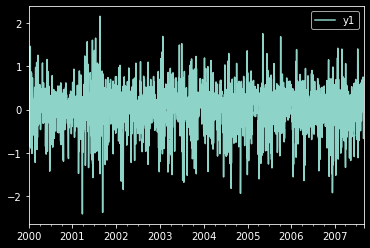

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.08s/it]


-> ACCEPT STRATEGY

** Performance summary **

Return:  4.13054575119332
Standard deviation:  2.6957258840253546
Sharpe:  1.5322573321236355

Return fee=0:  4.13054575119332
Standard deviation fee=0:  2.6957258840253546
Sharpe fee=0:  1.5322573321236355

**


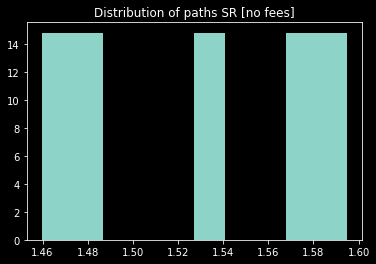

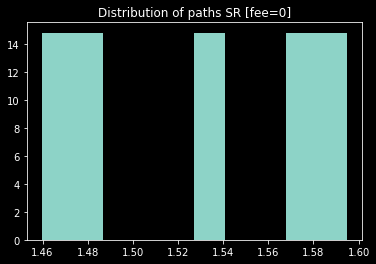

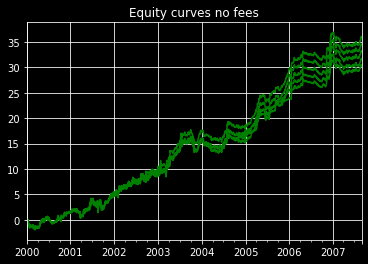

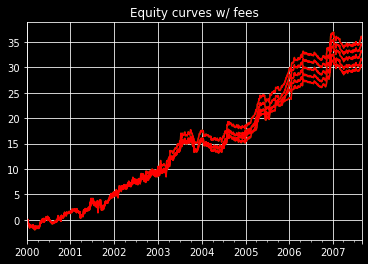

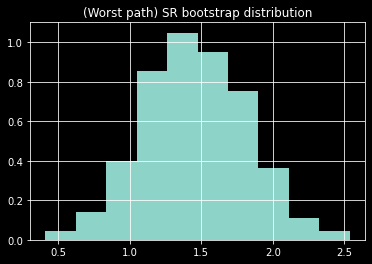

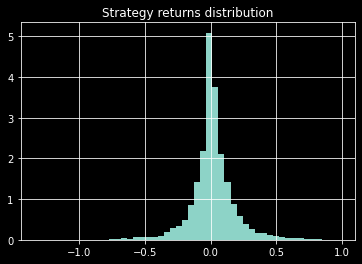

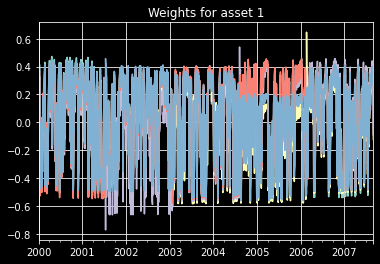

In [8]:
# hmm
# simple HMM 
# simulate and fit
A=np.array([
            [0.9,0.1],
            [0.1,0.9]
        ]) # state transition

P=np.array([0.5,0.5]) # initial state distribution

means=[
        np.array([0.1]),
        np.array([-0.1])
    ] # let the means be different from zero 

# list of covariance matrices (for each mixture)
covs=[
    np.array([[0.1]]),
    np.array([[0.5]])
]
# number of data points to generate
n=2000 
x,z=seqm.simulate_hmm(n,A,P,means,covs)

dates=pd.date_range('2000-01-01',periods=n,freq='B')
data=pd.DataFrame(x,columns=['y1'],index=dates)
data.plot()
plt.show()


A_zeros=[]#[[0,2],[0,3],[1,0],[1,1],[2,2],[2,3],[3,0],[3,1]]
A_groups=[]#[[0,2],[1,3]]

model=seqm.GaussianHMM(n_states=2,n_gibbs=250,A_zeros=A_zeros,A_groups=A_groups)
bt=seqm.Inference(
                        k_folds=5,
                        burn_f=0.1,
                        n_paths=5,   
                        )
out=bt.cvbt(data,model)
out.post_process()


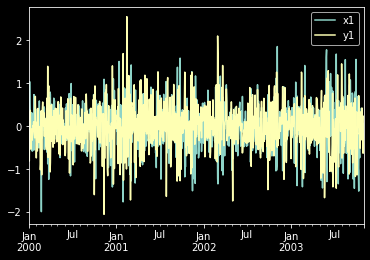

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.12s/it]


-> ACCEPT STRATEGY

** Performance summary **

Return:  10.143265688548324
Standard deviation:  2.265773637122176
Sharpe:  4.47673391655822

Return fee=0:  10.143265688548324
Standard deviation fee=0:  2.265773637122176
Sharpe fee=0:  4.47673391655822

**


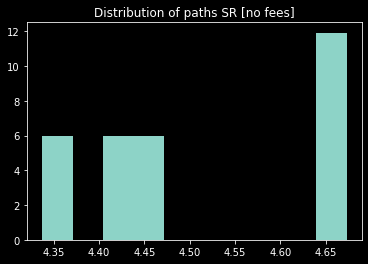

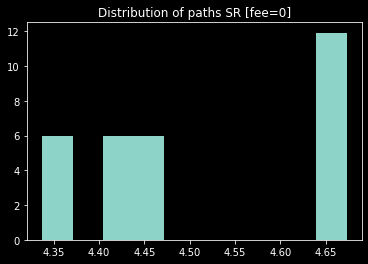

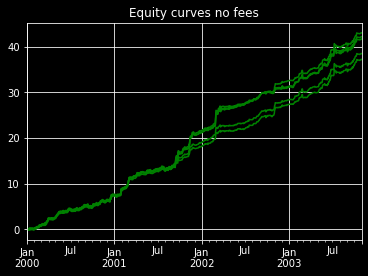

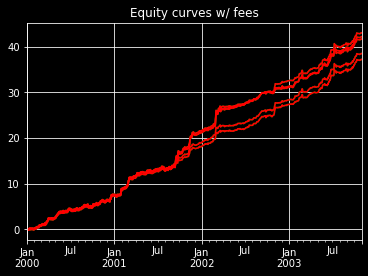

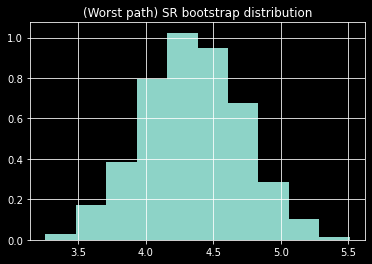

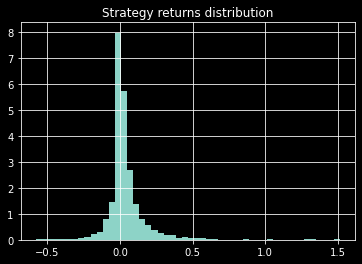

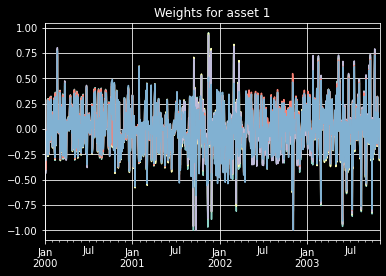

In [9]:
# io hmm - we can add features for example, autoregressive term 
# and run this model

A=np.array([[0.9,0.1],[0.1,0.9]]) # state transition
P=np.array([0.5,0.5]) # initial state distribution
means=[np.array([0.,0.]),np.array([0.,0.])]
# list of covariance matrices (for each mixture)
covs=[
    np.array([[0.1,0.05],[0.05,0.1]]),
    np.array([[0.5,-0.2],[-0.2,0.5]])
]
# number of data points to generate
n=1000 
samples,z=seqm.simulate_hmm(n,A,P,means,covs)
x=samples[:,0]
y=samples[:,1]

dates=pd.date_range('2000-01-01',periods=n,freq='B')
data=pd.DataFrame(np.hstack((y[:,None],x[:,None])),columns=['x1','y1'],index=dates)
data.plot()
plt.show()

A_zeros=[]#[[0,2],[0,3],[1,0],[1,1],[2,2],[2,3],[3,0],[3,1]]
A_groups=[]#[[0,2],[1,3]]

model=seqm.ConditionalGaussianHMM(n_states=2,n_gibbs=500,A_zeros=A_zeros,A_groups=A_groups)
bt=seqm.Inference(
                        k_folds=5,
                        burn_f=0.1,
                        n_paths=5,   
                        )
out=bt.cvbt(data,model)
out.post_process()


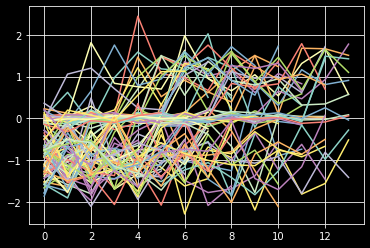

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.72s/it]


-> ACCEPT STRATEGY

** Performance summary **

Return:  85.90276151726147
Standard deviation:  6.585743765625197
Sharpe:  13.043744878997208

Return fee=0:  85.90276151726147
Standard deviation fee=0:  6.585743765625197
Sharpe fee=0:  13.043744878997208

**


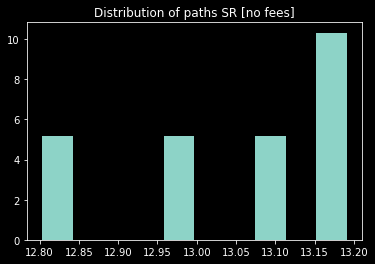

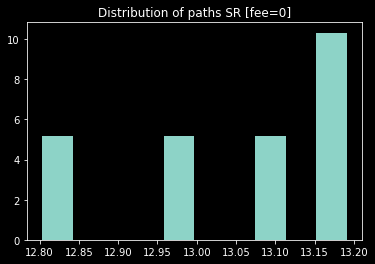

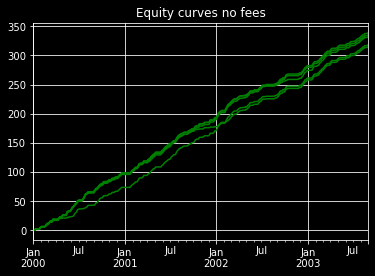

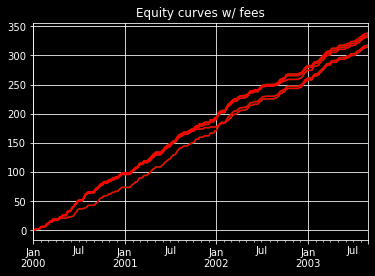

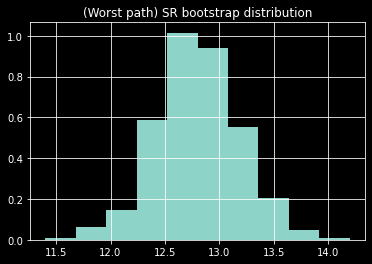

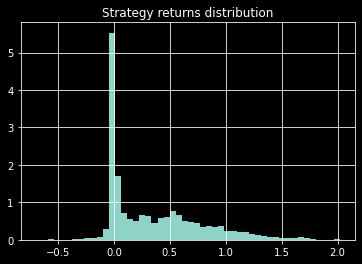

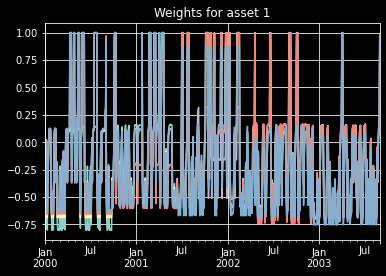

In [10]:
# multisequence HMM - usefull to model behaviour in a cyclic way
# simulate and fit
A=np.array([
            [0.9,0.1,0],
            [0,0.9,0.1],
            [0,0,1.]
        ]) # state transition

P=np.array([0.7,0.3,0]) # initial state distribution

means=[
        np.array([-1]),
        np.array([0.]),
        np.array([1])
    ] # let the means be different from zero 

# list of covariance matrices (for each mixture)
covs=[
    np.array([[0.25]]),
    np.array([[0.01]]),
    np.array([[0.25]])
]

k=100
n_min=5
n_max=15
o=[]
msidx=[]
for i in range(k):
    n=np.random.randint(n_min,n_max)
    x_,z_=seqm.simulate_hmm(n,A,P,means,covs)
    o.append(x_)
    msidx.append(i*np.ones(x_.shape[0],dtype=int)[:,None])
    plt.plot(x_)
plt.grid(True)
plt.show()

y=np.vstack(o)  
msidx=np.vstack(msidx)


dates=pd.date_range('2000-01-01',periods=y.shape[0],freq='B')
data=pd.DataFrame(np.hstack((y,msidx)),columns=['y1','idx'],index=dates)

A_zeros=[[0,2],[1,0],[2,0],[2,1]]
A_groups=[]


model=seqm.GaussianHMM(n_states=3,n_gibbs=250,A_zeros=A_zeros,A_groups=A_groups)

bt=seqm.Inference(
                        k_folds=5,
                        burn_f=0.1,
                        n_paths=5,   
                        )
out=bt.cvbt(data,model)
out.post_process()


In [11]:
# use actual data 
# SPY returns
# predict with previous fluctuation
data=pd.read_csv('data.csv',index_col='Dates')
data=data.pct_change()
data=data.dropna()

data

,SPY US Equity,IEF US Equity
Dates,,
29/07/2002,0.048715,-0.011715
30/07/2002,0.013034,-0.000612
31/07/2002,0.002420,0.009172
01/08/2002,-0.026109,0.004120
02/08/2002,-0.022414,0.007725
...,...,...
14/08/2023,0.005520,-0.001594
15/08/2023,-0.011649,-0.001915
16/08/2023,-0.007338,-0.003838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:37<00:00,  7.56s/it]


-> ACCEPT STRATEGY

** Performance summary **

Return:  0.03881103626563146
Standard deviation:  0.042711680170055506
Sharpe:  0.9086750067219616

Return fee=0.0001:  0.0371190300529116
Standard deviation fee=0.0001:  0.04271411500642409
Sharpe fee=0.0001:  0.869010865549456

Return fee=0.0002:  0.03542702384019175
Standard deviation fee=0.0002:  0.042717323529898765
Sharpe fee=0.0002:  0.8293362250421804

**


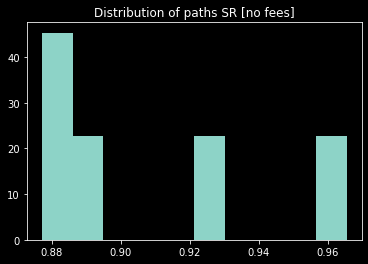

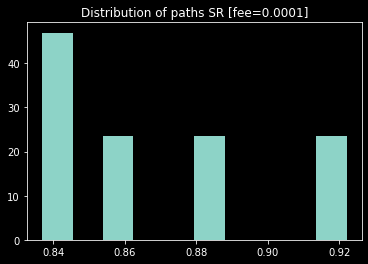

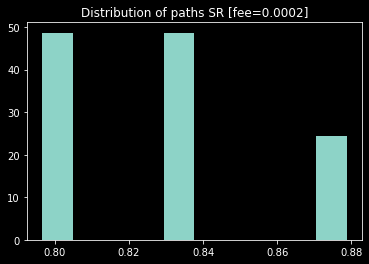

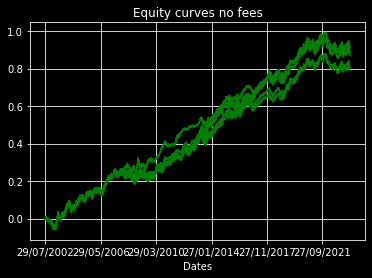

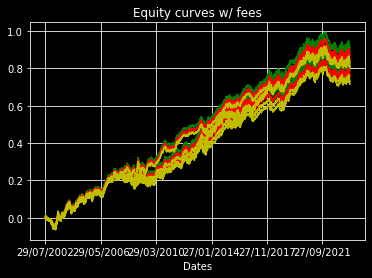

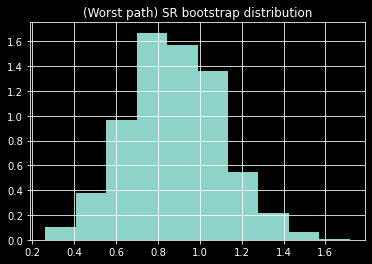

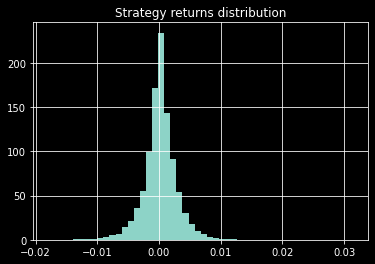

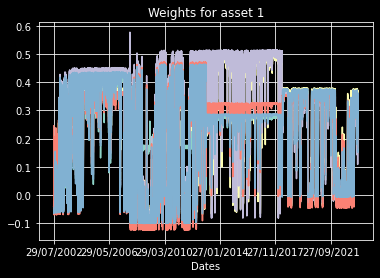

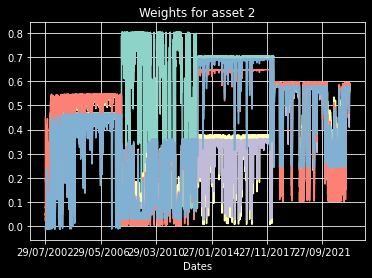

In [13]:
d=data[['SPY US Equity','IEF US Equity']].copy() 
d.columns=['y1','y2']

A_zeros=[]#[[0,2],[0,3],[1,0],[1,1],[2,2],[2,3],[3,0],[3,1]]
A_groups=[]#[[0,2],[1,3]]

model=seqm.GaussianHMM(n_states=2,n_gibbs=100,A_zeros=A_zeros,A_groups=A_groups)


bt=seqm.Inference(
                        k_folds=4,
                        burn_f=0.1,
                        n_paths=5,
                        seq_fees=True,
                        pct_fees=[0.01/100,0.02/100]
                        )
out=bt.cvbt(d,model)
out.post_process()



-> REJECT STRATEGY

** Performance summary **

Return:  0.03881103626563146
Standard deviation:  0.042711680170055506
Sharpe:  0.9086750067219616

Return fee=0.0001:  0.0371190300529116
Standard deviation fee=0.0001:  0.04271411500642409
Sharpe fee=0.0001:  0.869010865549456

Return fee=0.0002:  0.03542702384019175
Standard deviation fee=0.0002:  0.042717323529898765
Sharpe fee=0.0002:  0.8293362250421804

Return fee=0.0004:  0.032043011414752055
Standard deviation fee=0.0004:  0.04272606089893394
Sharpe fee=0.0004:  0.7499640907816887

**


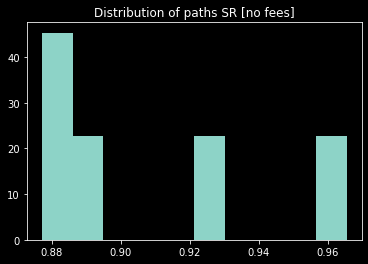

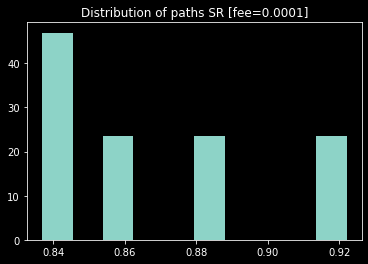

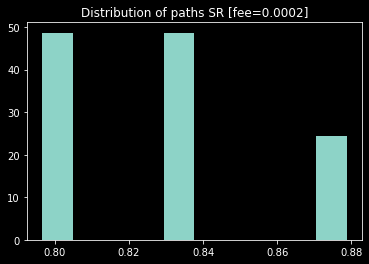

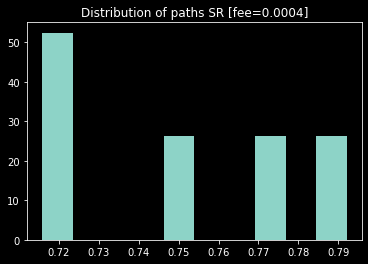

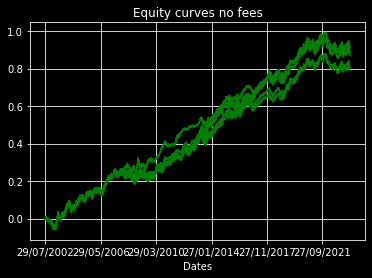

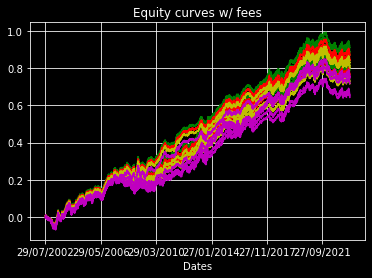

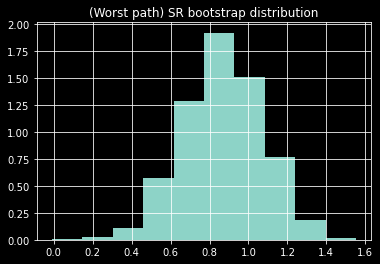

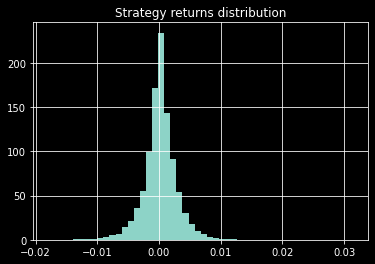

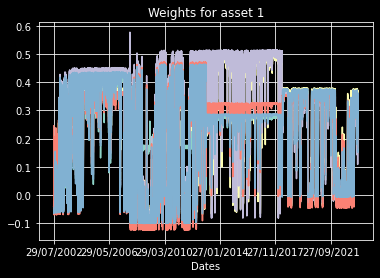

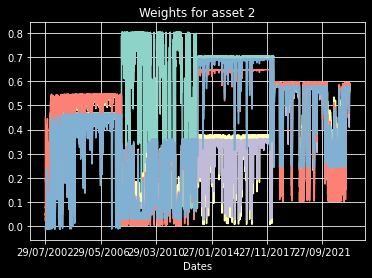

In [14]:
# we can post process and insert new fees!
out.post_process(seq_fees=True,pct_fees=[0.01/100,0.02/100,0.04/100])

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

                  y1        x1
Dates                         
29/07/2002  0.048715       NaN
30/07/2002  0.013034  0.048715
31/07/2002  0.002420  0.013034
01/08/2002 -0.026109  0.002420
02/08/2002 -0.022414 -0.026109
...              ...       ...
14/08/2023  0.005520 -0.000583
15/08/2023 -0.011649  0.005520
16/08/2023 -0.007338 -0.011649
17/08/2023 -0.007620 -0.007338
18/08/2023  0.000481 -0.007620

[5495 rows x 2 columns]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.83s/it]


-> ACCEPT STRATEGY

** Performance summary **

Return:  0.07245003040446062
Standard deviation:  0.08552173788154203
Sharpe:  0.8471533927995322

Return fee=0.0001:  0.06732644309756924
Standard deviation fee=0.0001:  0.08550206533844094
Sharpe fee=0.0001:  0.7874247578824262

**


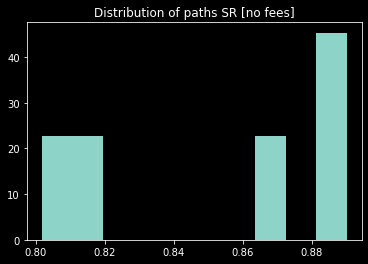

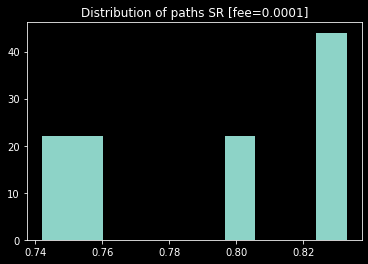

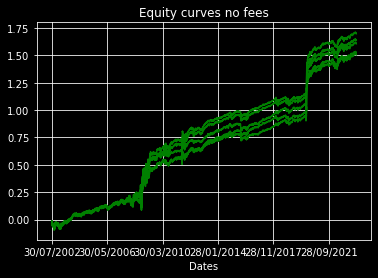

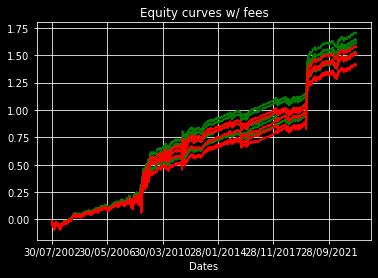

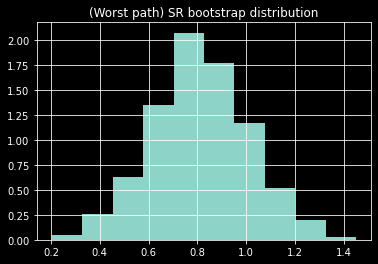

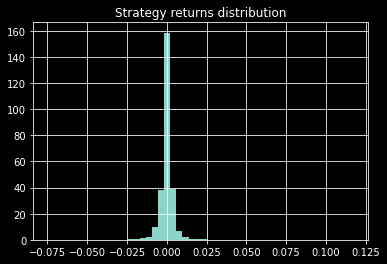

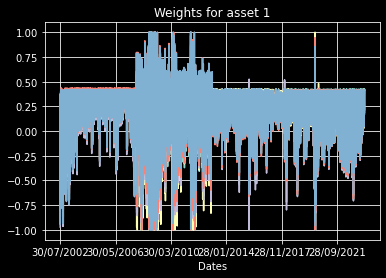

In [15]:
# ar hmm
#d=data[['SPY US Equity','IEF US Equity']].copy() 
d=data[['SPY US Equity']].copy() 
d.columns=['y1']
d['x1']=d['y1'].shift(1)
#d['x2']=d['y2'].shift(1)
print(d)
d=d.dropna()


A_zeros=[]#[[0,2],[0,3],[1,0],[1,1],[2,2],[2,3],[3,0],[3,1]]
A_groups=[]#[[0,2],[1,3]]

# model=GaussianHMM(n_states=3,n_gibbs=1000,A_zeros=A_zeros,A_groups=A_groups)
model=seqm.ConditionalGaussianMixture(n_states=2,n_gibbs=500)#,A_zeros=A_zeros,A_groups=A_groups)



bt=seqm.Inference(
                        k_folds=4,
                        burn_f=0.1,
                        n_paths=5,   
                        seq_fees=True,
                        pct_fees=0.01/100
                        )
out=bt.cvbt(d,model)
out.post_process()



In [20]:
filapath='something.pkl'
print(filapath[-100:])

something.pkl


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

DATA
            ES1 A:00_0_R Index  NQ1 A:00_0_R Index  VG1 A:00_0_R Index  \
DATE                                                                     
1990-01-02                 NaN                 NaN                 NaN   
1990-01-03                 NaN                 NaN                 NaN   
1990-01-04                 NaN                 NaN                 NaN   
1990-01-05                 NaN                 NaN                 NaN   
1990-01-08                 NaN                 NaN                 NaN   
...                        ...                 ...                 ...   
2023-12-05             4627.38            16116.77              4458.0   
2023-12-06             4608.16            16022.05              4495.0   
2023-12-07             4642.04            16248.47              4478.0   
2023-12-08             4660.25            16308.75              4527.0   
2023-12-11             4666.75            16411.25              4550.0   

            FV1 A:00_0_R Comdty 

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.06s/it]


-> REJECT STRATEGY

** Performance summary **

Return:  0.03613877117260316
Standard deviation:  0.049229359645582844
Sharpe:  0.734089808049042

Return fee=0.0001:  0.03532163413266581
Standard deviation fee=0.0001:  0.049227401572837455
Sharpe fee=0.0001:  0.717519775655912

**


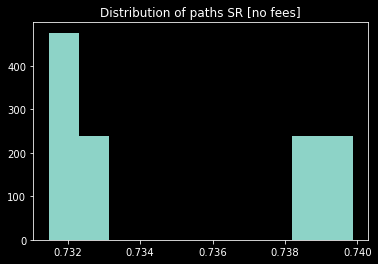

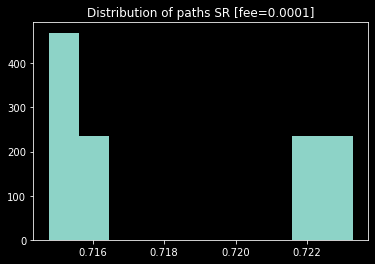

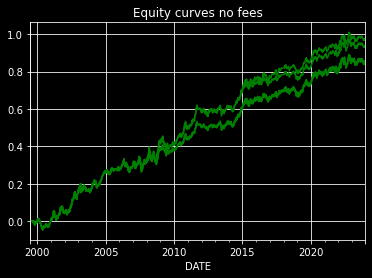

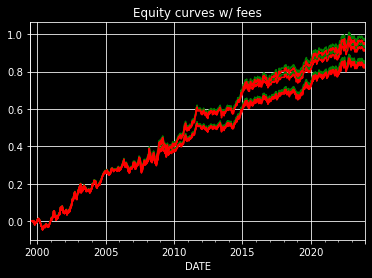

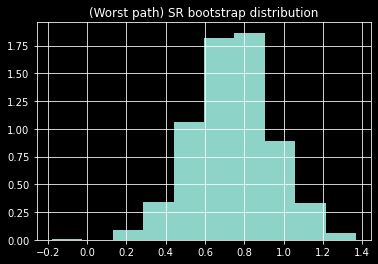

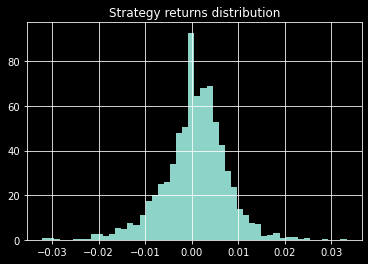

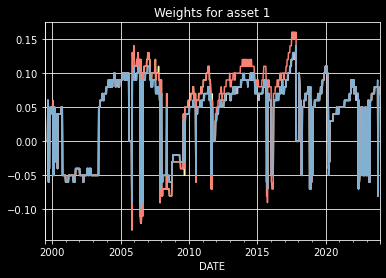

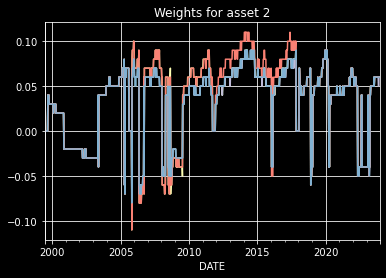

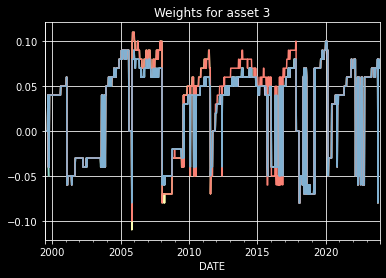

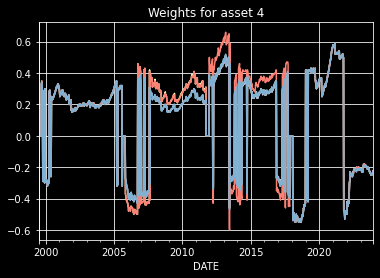

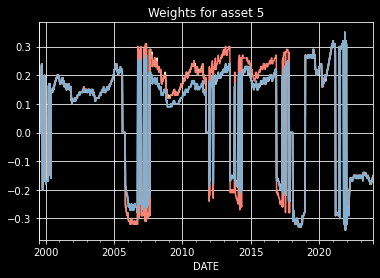

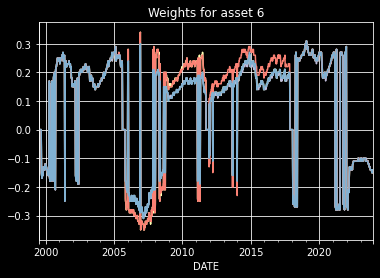

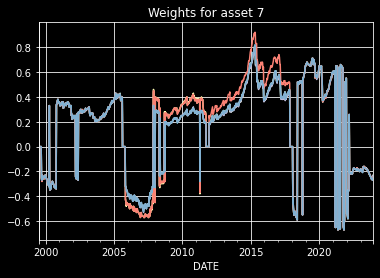

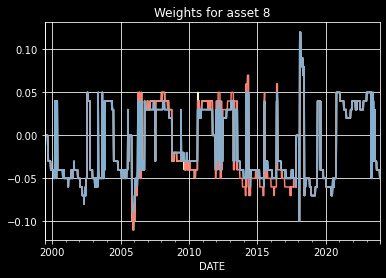

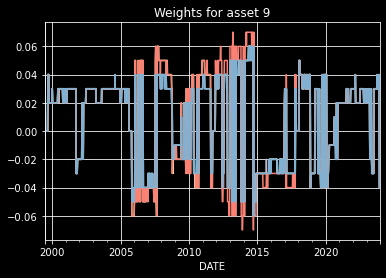

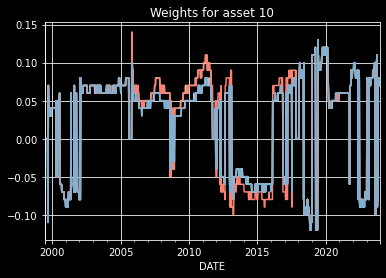

In [16]:
# TRACKING MODEL!


tmp=pd.read_csv('data_many.csv',index_col='DATE',parse_dates=True)
tmp

data=tmp.copy(deep=True)
print('DATA')
print(data)
print('------------------------------------')
print()

data=data.dropna()


data=data.resample('W-FRI').last()
data=data.pct_change()

data=data.dropna()
print('DATA')
print(data)



#data=pd.read_csv('data.csv',index_col='Dates')
#data.index=pd.to_datetime(data.index,format='%d/%m/%Y')
#data=data.resample('W').last()
#data=data.pct_change()
#data=data.dropna()

d=data
d.columns=['y%s'%i for i in range(len(d.columns))]
#d=data[['SPY US Equity','IEF US Equity']].copy() 
#d.columns=['y1','y2']
print(d)
d=d.dropna()


A_zeros=[]#[[0,2],[0,3],[1,0],[1,1],[2,2],[2,3],[3,0],[3,1]]
A_groups=[]#[[0,2],[1,3]]

# model=GaussianHMM(n_states=3,n_gibbs=1000,A_zeros=A_zeros,A_groups=A_groups)
model=seqm.GaussianTrack(
                        phi=0.95,
                        phi_m=0.98,
                        min_l=10,
                        max_l=100,
                        diag_cov=True,
                        eq_sharpe=True,
                        min_points_stats=10,
                        quantile=0.9,
                        leverage=2,
                        
                        )


bt=seqm.Inference(
                        k_folds=4,
                        burn_f=0.1,
                        n_paths=5,
                        seq_fees=True,
                        pct_fees=0.01/100,
                        sr_mult=np.sqrt(52)
                        )
out=bt.cvbt(d,model)
out.post_process()



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

                  x0        x1        x2        x3        x4        x5  \
DATE                                                                     
1999-07-02  0.044536  0.057484  0.029456  0.010391  0.012648  0.002965   
1999-07-09  0.009265  0.018544  0.019314  0.000000  0.000797 -0.010981   
1999-07-16  0.010318  0.026791  0.000507  0.003955  0.006107 -0.001566   
1999-07-23 -0.036454 -0.059112 -0.046489 -0.000900 -0.003167  0.011121   
1999-07-30 -0.013161 -0.008883 -0.054028 -0.005858 -0.006619 -0.007191   
...              ...       ...       ...       ...       ...       ...   
2023-11-17  0.036909  0.042049  0.016745  0.008135  0.012455  0.005810   
2023-11-24  0.009727  0.009545  0.012062 -0.001320 -0.000429  0.000152   
2023-12-01  0.002080 -0.003972  0.006418  0.004628  0.005581  0.008207   
2023-12-08  0.002785  0.003331  0.019813  0.007165  0.012381  0.021030   
2023-12-15  0.003923  0.003710  0.010942 -0.006098 -0.008012 -0.005758   

                  x6        x7       

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


-> REJECT STRATEGY

** Performance summary **

Return:  0.03312735626157236
Standard deviation:  0.04664421135620247
Sharpe:  0.7102136642121034

Return fee=0.0001:  0.03236377474238676
Standard deviation fee=0.0001:  0.04663939953167991
Sharpe fee=0.0001:  0.6939149102981825

**


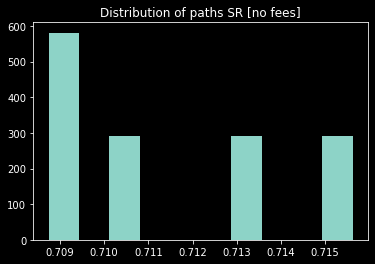

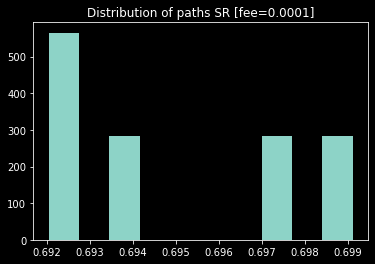

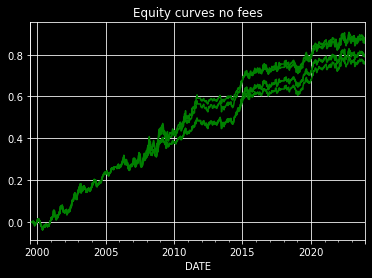

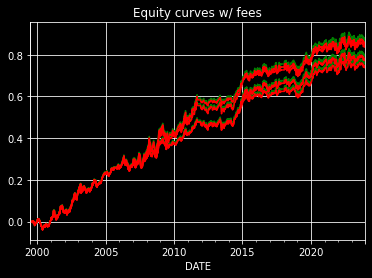

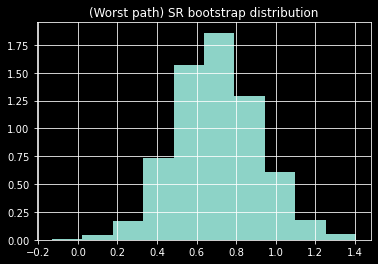

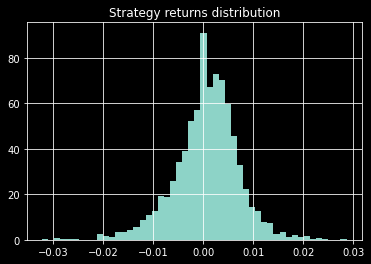

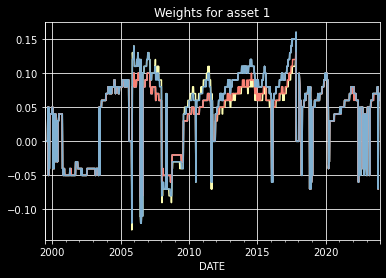

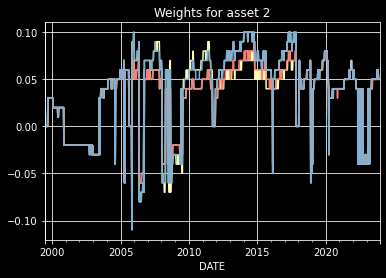

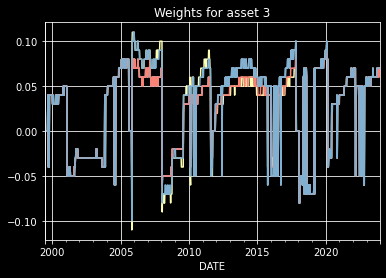

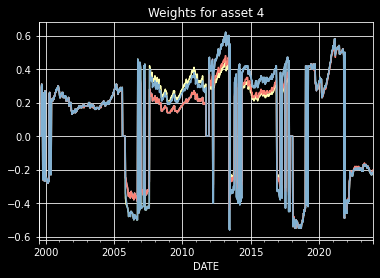

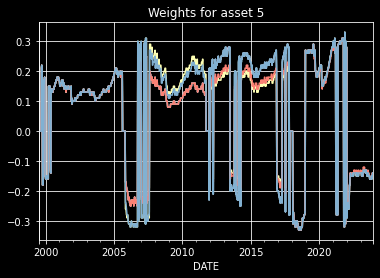

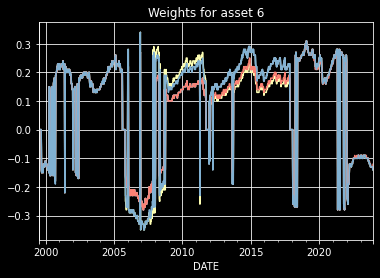

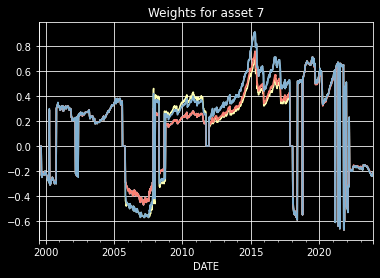

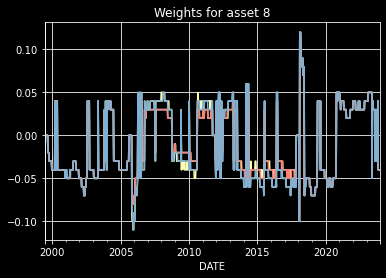

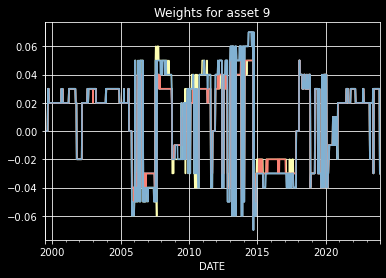

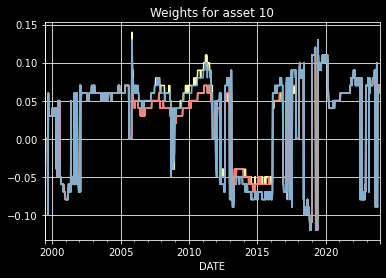

In [17]:
# TRACKING MODEL WITH DATA DELAY - example how to use
# in this case we want to make decision with data from thursday!


data=pd.read_csv('data_many.csv',index_col='DATE',parse_dates=True)

data=data.dropna()
data_model=data.copy(deep=True)
data_model=data_model.shift(1)
data_model=data_model.iloc[1:]
data=data.iloc[1:]


data=data.resample('W-FRI').last()
data_model=data_model.resample('W-FRI').last()

data=data.pct_change()
data_model=data_model.pct_change()
data=data.dropna()
data_model=data_model.dropna()

data_model.columns=['x%s'%i for i in range(len(data_model.columns))]
data.columns=['y%s'%i for i in range(len(data.columns))]

data=pd.concat((data_model,data),axis=1)
data=data.dropna()


print(data)

# model=GaussianHMM(n_states=3,n_gibbs=1000,A_zeros=A_zeros,A_groups=A_groups)
model=seqm.GaussianTrack(
                        phi=0.95,
                        phi_m=0.98,
                        min_l=10,
                        max_l=300,
                        diag_cov=True,
                        eq_sharpe=True,
                        min_points_stats=10,
                        quantile=0.99,
                        leverage=2,
                        use_x_data=False                        
                        )



bt=seqm.Inference(
                        k_folds=4,
                        burn_f=0.1,
                        n_paths=5,
                        seq_fees=True,
                        pct_fees=0.01/100,
                        sr_mult=np.sqrt(52)
                        )
out=bt.cvbt(data,model)
out.post_process()


